## Imports and Preliminaries

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import timm
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader
from scipy.spatial.distance import cosine
import timm
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

sns.set_style("whitegrid")


def accuracy(target, pred):
    return accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

def show_image(img, title=None):
    # img = img.detach().cpu()
    img = img.permute((1, 2, 0)).numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean   # unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.gca().tick_params(axis="both", which="both", bottom=False, left=False, labelbottom=False, labelleft=False)
    if title is not None:
        plt.title(title)

Using device: cpu


## Dataset Class

In [3]:
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms


class MVTecDataset(Dataset):
    def __init__(self, root_dir, category, split="train", transform=None, cache=False):
        """
        Args:
            root_dir: Path to MVTec AD dataset root.
            category: Product category (e.g., 'bottle', 'cable', 'capsule').
            split: 'train' or 'test'.
            transform: torchvision transforms.
            cache: If True, images are pre-loaded into RAM for faster epochs.
        """
        self.root_dir = Path(root_dir)
        self.category = category
        self.split = split
        self.transform = transform
        self.cache = cache

        base_dir = self.root_dir / category / split

        if split == "train":
            img_dirs = [(base_dir / "good", 0, "good")]
        else:
            # Each folder inside 'test' is a defect type
            img_dirs = [
                (d, 0 if d.name == "good" else 1, d.name)
                for d in base_dir.iterdir()
                if d.is_dir()
            ]

        self.image_paths = []
        self.labels = []
        self.defect_types = []

        for folder, lbl, defect in img_dirs:
            for img_path in sorted(folder.glob("*.png")):
                self.image_paths.append(img_path)
                self.labels.append(lbl)
                self.defect_types.append(defect)

        # Optional RAM caching
        self.cached_images = None
        if cache:
            self.cached_images = [
                Image.open(p).convert("RGB") for p in self.image_paths
            ]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # if self.cache:
        #     img = self.cached_images[idx]
        # else:
        img = Image.open(self.image_paths[idx]).convert("RGB")

        if self.transform:
            img = self.transform(img)

        label = self.labels[idx]
        defect_type = self.defect_types[idx]

        return img, defect_type

## Create Datasets

In [4]:
from torch.utils.data import ConcatDataset
import os

MVTEC_ROOT = "./Dataset"
BATCH_SIZE = 40
IMAGE_SIZE = 224

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

root_dir = Path(MVTEC_ROOT)

all_categories = [cat.name for cat in root_dir.iterdir() if cat.is_dir()]
print(all_categories)


def get_transforms(image_size=224, mean=imagenet_mean, std=imagenet_std):
    return transforms.Compose(
        [
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ]
    )

transform = get_transforms(IMAGE_SIZE)

def build_concat(split):
    datasets = [
        MVTecDataset(MVTEC_ROOT, cat, split=split, transform=transform)
        for cat in all_categories
    ]
    return ConcatDataset(datasets)


train_dataset = build_concat("train")
test_dataset = build_concat("test")

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, num_workers=0, shuffle=False, pin_memory=False)

test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, num_workers=0, shuffle=False)

['bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather', 'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper']


TRAINING IMAGES


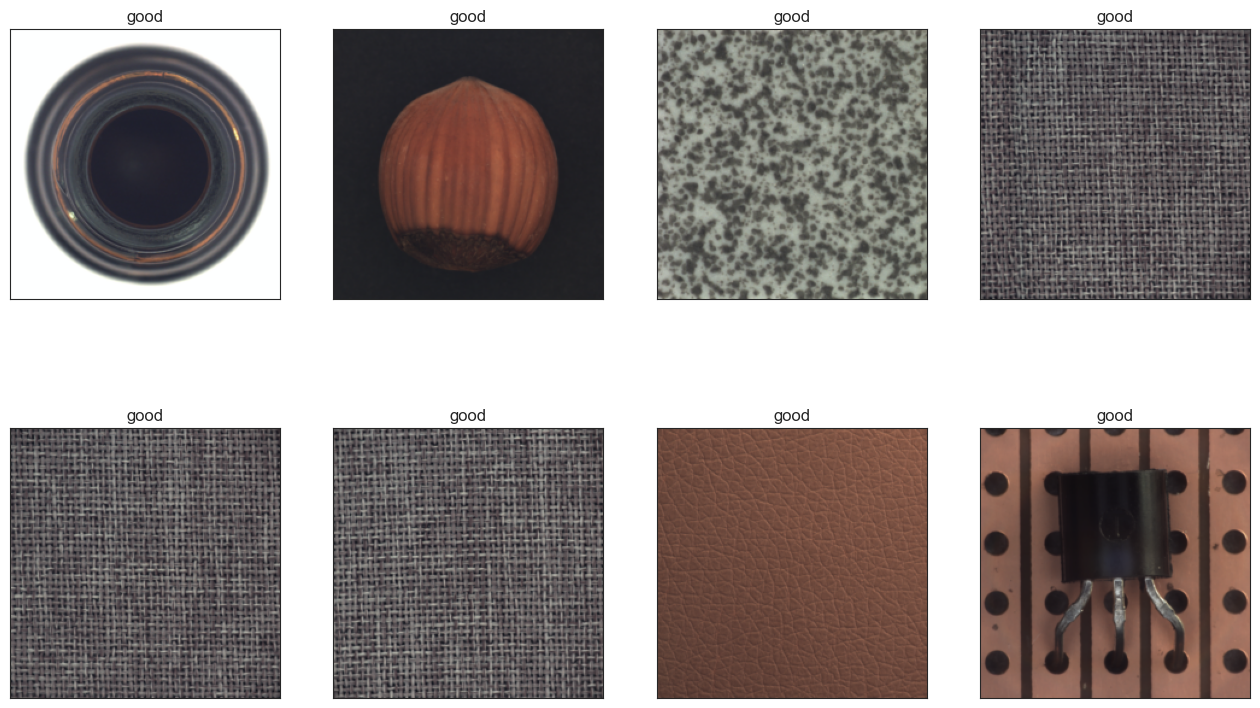

TESTING IMAGES


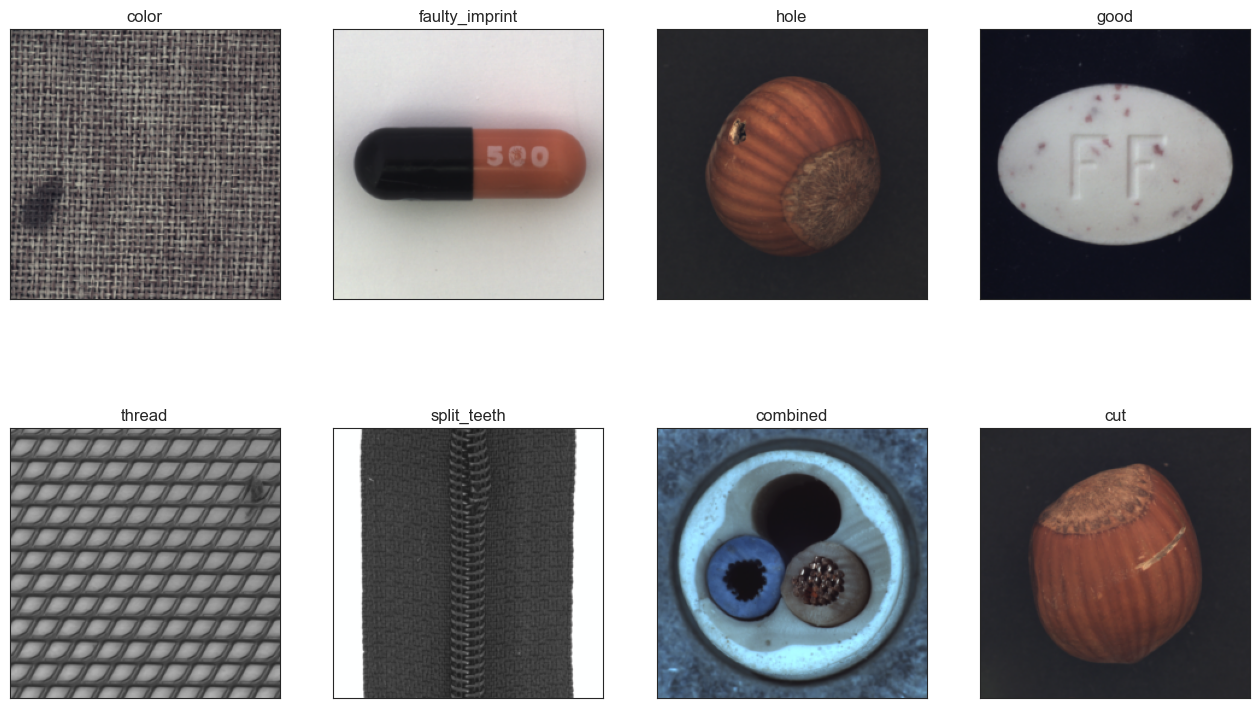

In [5]:
def show_dataset_examples(dataloader):
    images, labels = next(iter(dataloader))

    with sns.axes_style("white"):
        fig, axes = plt.subplots(2, 4, figsize=(16, 9.5))

    axes = [ax for row in axes for ax in row]

    for j, ax in enumerate(axes[:8]):
        img = images[j]
        label = labels[j]

        plt.sca(ax)
        show_image(img, label)

    plt.show()


train_example_loader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True)

test_example_loader = DataLoader(dataset=test_dataset, batch_size=8, shuffle=True)

print("TRAINING IMAGES")
show_dataset_examples(train_example_loader)
print("TESTING IMAGES")
show_dataset_examples(test_example_loader)

## Embed training features, compare to Test data and draw conclusion

In [6]:
EMBEDDING_FILE_EXT = "embeddings.npz"

def save_embeddings_compressed(embeddings, save_path="./embeddings", dataset_name="train"):
    """
    Args:
        embeddings: List of (embedding, label) tuples
        save_path: Directory to save files
        dataset_name: Base name for the files
    """
    save_path = Path(save_path)
    save_path.mkdir(parents=True, exist_ok=True)

    # Separate embeddings and labels
    emb_arrays = np.array([emb for emb, _ in embeddings])
    labels = np.array([label for _, label in embeddings])

    # Save as compressed numpy
    npz_path = save_path / f"{dataset_name}_{EMBEDDING_FILE_EXT}"
    np.savez_compressed(npz_path, embeddings=emb_arrays, labels=labels)

    print(f"Compressed embeddings saved to: {npz_path}")
    print(f"File size: {os.path.getsize(npz_path) / 1e6:.2f} MB")

    return npz_path


def load_embeddings_compressed(npz_path, n_register_tokens=4):
    """
    Load embeddings from compressed numpy format.

    Args:
        npz_path: Path to .npz file

    Returns:
        embeddings: List of (embedding_array, label) tuples
    """
    print(f"Loading compressed embeddings from: {npz_path}")

    data = np.load(npz_path)
    emb_arrays = data["embeddings"]  # shape: (N_images, N_tokens, D)
    labels = data["labels"]

    # Remove register tokens from each image
    if n_register_tokens > 0:
        emb_arrays = emb_arrays[:, n_register_tokens:, :]

    # Convert to list of tuples
    embeddings = [(emb_arrays[i], labels[i]) for i in range(len(labels))]

    print(
        f"Loaded {len(embeddings)} embeddings with shape {emb_arrays.shape[1:]} per image"
    )

    return embeddings

In [7]:
def embed_and_save_features(
    dataloader, split, model_url="vit_small_patch16_dinov3_qkvb.lvd1689m", device="cuda"
):
    """
    Efficient, stable DINOv3 patch embedding extractor.
    Uses mean pooling over patch tokens → 384-dim embeddings.
    """
    model = timm.create_model(model_url, pretrained=True).to(device)
    model.eval()

    embeddings = []

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(dataloader):

            images = images.to(device)

            feats = model.forward_features(images)

            if isinstance(feats, dict):
                x = feats.get("x_norm")  
            else:
                x = feats

            emb = x.mean(dim=1)

            emb = emb.cpu().numpy()

            for i, label in enumerate(labels):
                lbl = label.item() if isinstance(label, torch.Tensor) else label
                embeddings.append((emb[i], lbl))

            if (batch_idx + 1) % 10 == 0:
                print(f"Processed {batch_idx+1} batches")

    save_embeddings_compressed(embeddings=embeddings, dataset_name=split, save_path='./NEW_embeddings')
    return embeddings

In [8]:
import csv 
def cosine_sim_matrix(test_vec, gt_mat):
    """
    test_vec: (384,)
    gt_mat:   (N, 384)
    returns:  (N,)
    """
    return (gt_mat @ test_vec).ravel() 


def compare_and_draw_conclusion(
    threshold=0.8, rank=10, csv_path="results.csv", embedding_folder="./embeddings"
):
    train_path = f"{embedding_folder}/train_{EMBEDDING_FILE_EXT}"
    test_path = f"{embedding_folder}/test_{EMBEDDING_FILE_EXT}"

    embeddings_GT = (
        load_embeddings_compressed(train_path)
        if os.path.exists(train_path)
        else embed_and_save_features(train_loader, "train")
    )

    embeddings_Test = (
        load_embeddings_compressed(test_path)
        if os.path.exists(test_path)
        else embed_and_save_features(test_loader, "test")
    )

    gt_vecs, _ = zip(*embeddings_GT)
    gt_mat = np.asarray(gt_vecs, dtype=np.float32)

    # Normalize GT matrix once
    gt_mat /= np.linalg.norm(gt_mat, axis=1, keepdims=True) + 1e-8

    results = []
    correct = 0
    total = 0

    for idx, (test_vec, label) in enumerate(embeddings_Test):

        tv = np.asarray(test_vec, dtype=np.float32)
        tv /= np.linalg.norm(tv) + 1e-8

        sims = cosine_sim_matrix(tv, gt_mat)  # vectorized

        # select rank-th highest similarity
        kth = np.partition(sims, -rank)[-rank] if len(sims) >= rank else sims.max()

        pred = "good" if kth > threshold else "anomalous"
        true = "good" if str(label).lower() == "good" else "anomalous"

        ok = int(pred == true)
        correct += ok
        total += 1

        results.append(
            {
                "Test_Index": total,
                "True_Label": true,
                "Predicted_Label": pred,
                f"{rank}th_Best_Similarity": kth,
                "Correct": ok,
            }
        )

    acc = correct / total if total else 0

    results.append(
        {
            "Test_Index": "TOTAL",
            "True_Label": "",
            "Predicted_Label": "",
            f"{rank}th_Best_Similarity": "",
            "Correct": f"{acc*100:.2f}% ({correct}/{total})",
        }
    )

    with open(csv_path, "w", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=results[0].keys())
        writer.writeheader()
        writer.writerows(results)

    print(f"Saved: {csv_path}")
    return acc

In [9]:
# on GPU it takes roughly 3 minutes 18s to process all training and testing embeddings

compare_and_draw_conclusion(threshold=0.97, rank=25)

Loading compressed embeddings from: ./embeddings/train_embeddings.npz


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [ ]:
import numpy as np


def load_embeddings_only(path, max_samples=None):
    data = np.load(path, allow_pickle=True)

    if "embeddings" in data:
        X = data["embeddings"]
        y = data.get("labels", None)
    else:
        pairs = data["arr_0"]
        X = np.stack([e for e, _ in pairs])
        y = np.array([l for _, l in pairs])

    if max_samples is not None:
        X = X[:max_samples]
        if y is not None:
            y = y[:max_samples]

    return X, y

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


def visualize_pca(embeddings, labels=None, title="PCA visualization"):

    embeddings = embeddings / (np.linalg.norm(embeddings, axis=1, keepdims=True) + 1e-8)

    pca = PCA(n_components=2)
    Xp = pca.fit_transform(embeddings)

    plt.figure(figsize=(8, 6))

    if labels is None:
        plt.scatter(Xp[:, 0], Xp[:, 1], s=8, alpha=0.7)
    else:
        labels = labels.astype(str)
        for lbl in np.unique(labels):
            idx = labels == lbl
            plt.scatter(
                Xp[idx, 0],
                Xp[idx, 1],
                s=10,
                alpha=0.7,
                label=lbl,
            )
        plt.legend()

    var = pca.explained_variance_ratio_ * 100
    plt.xlabel(f"PC1 ({var[0]:.1f}%)")
    plt.ylabel(f"PC2 ({var[1]:.1f}%)")
    plt.title(title)
    plt.grid(True)
    plt.show()

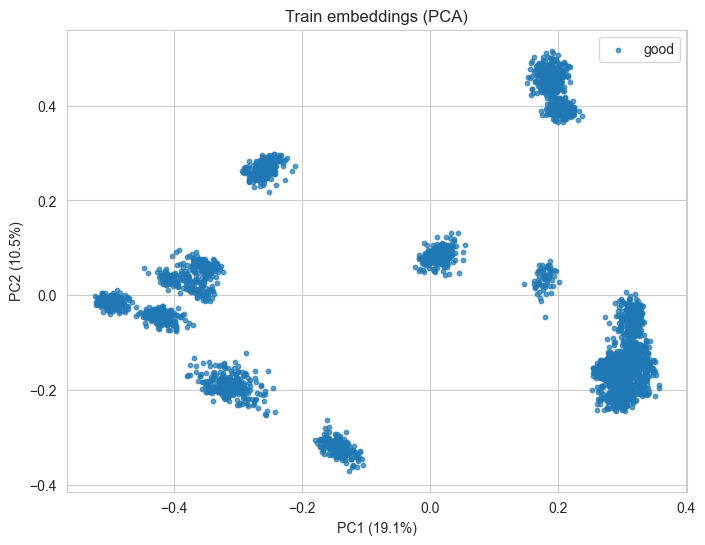

In [ ]:
train_path = f"./embeddings/train_{EMBEDDING_FILE_EXT}"
test_path = f"./embeddings/test_{EMBEDDING_FILE_EXT}"

X_test, y_test = load_embeddings_only(
    train_path,
)
visualize_pca(X_test, y_test, "Train embeddings (PCA)")

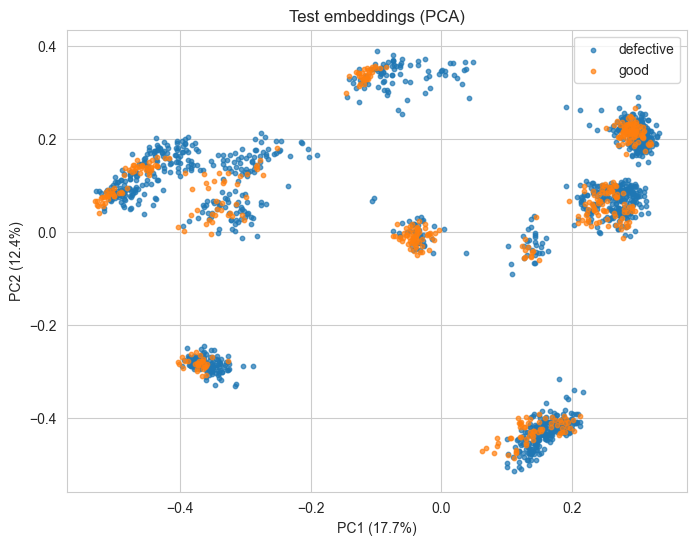

In [ ]:
X_test, y_test = load_embeddings_only(
    test_path,
)

y_bin = ["good" if str(label).lower() == "good" else "defective" for label in y_test ]

y_bin = np.array(y_bin)

visualize_pca(X_test, y_bin, "Test embeddings (PCA)")

In [ ]:
def extract_patch_embeddings(
    dataloader, split, model_url="vit_small_patch16_dinov3_qkvb.lvd1689m"
):
    """
    Extract patch embeddings for all images in a dataloader.
    Returns: patches_embeddings [N_images, N_patches, D], labels [N_images]
    """
    model = timm.create_model(model_url, pretrained=True)
    model.eval().to(device)

    grid_size = model.patch_embed.grid_size
    print(grid_size)

    all_patches = []
    all_labels = []
    i = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            # Get patch features (no CLS token)
            feats = model.forward_features(images)
            if isinstance(feats, dict):
                patch_feats = feats.get("x_norm")  # shape: [B, N_patches, D]
            else:
                patch_feats = feats[:, 1:, :]  # drop CLS token if exists

            patch_feats = patch_feats.cpu().numpy()
            print("patch shape:", patch_feats.shape)
            all_patches.append(patch_feats)
            all_labels.extend(labels)

            print('loaded batch', i)
            i += 1
            # if i > 5: break

    all_patches = np.concatenate(all_patches, axis=0)
    all_labels = np.array(all_labels)

    embeddings = [(patch, label) for patch, label in zip(all_patches, all_labels)]

    save_embeddings_compressed(embeddings=embeddings, dataset_name=split, save_path='./NEW_embeddings')
    return all_patches, all_labels

In [ ]:
extract_patch_embeddings(train_loader, "train")

(16, 16)
patch shape: (40, 200, 384)
loaded batch 0
patch shape: (40, 200, 384)
loaded batch 1


KeyboardInterrupt: 

In [ ]:
import faiss



train_data = load_embeddings_compressed(f"./NEW_embeddings/train_{EMBEDDING_FILE_EXT}")
train_patches, train_labels = zip(*train_data)

test_data = load_embeddings_compressed(f"./NEW_embeddings/test_{EMBEDDING_FILE_EXT}")
test_patches, test_labels = zip(*test_data)

# unzip
train_patches_list, train_labels = zip(*train_data)
test_patches_list, test_labels = zip(*test_data)

# convert to float32 NumPy arrays
train_patches = np.stack([np.array(p, dtype=np.float32) for p in train_patches_list])
test_patches = np.stack([np.array(p, dtype=np.float32) for p in test_patches_list])

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# Flatten train/test patches to 2D arrays
num_train_images, num_patches_per_image, dim = train_patches.shape
num_test_images = test_patches.shape[0]

train_patches_flat = train_patches.reshape(-1, dim)  # (3629*200, 384)
test_patches_flat = test_patches.reshape(-1, dim)  # (1725*200, 384)
# now train_patches and test_patches are proper 2D arrays
print(train_patches_flat.shape, test_patches_flat.shape)


# L2-normalize
faiss.normalize_L2(train_patches_flat)
faiss.normalize_L2(test_patches_flat)

Loading compressed embeddings from: ./NEW_embeddings/train_embeddings.npz
Loaded 3629 embeddings with shape (196, 384) per image
Loading compressed embeddings from: ./NEW_embeddings/test_embeddings.npz
Loaded 1725 embeddings with shape (196, 384) per image
(711284, 384) (338100, 384)


In [ ]:
from sklearn.decomposition import PCA

# pca_dim = 128
# pca = PCA(n_components=pca_dim, whiten=True, svd_solver="randomized")
# memory_bank_reduced = pca.fit_transform(train_patches_flat)
# test_patches_reduced = pca.transform(test_patches_flat)

In [ ]:
# Ensure memory_bank_reduced and test_patches_reduced are contiguous
memory_bank_reduced = np.ascontiguousarray(memory_bank_reduced, dtype=np.float32)
test_patches_reduced = np.ascontiguousarray(test_patches_reduced, dtype=np.float32)

# Now normalize
faiss.normalize_L2(memory_bank_reduced)
faiss.normalize_L2(test_patches_reduced)

In [ ]:
dim = memory_bank_reduced.shape[1]
print(dim)
index = faiss.IndexFlatL2(dim)  # exact L2 search
index.add(memory_bank_reduced)

128


In [ ]:
# k = 5  # nearest neighbor
# distances, indices = index.search(test_patches_reduced, k)



In [154]:
np.savez_compressed("test_patch_knn.npz", distances=distances, indices=indices)

In [1]:
knn_data = np.load("test_patch_knn.npz", allow_pickle=True)

if "distances" in knn_data:
    distances = knn_data["data"]
    indices = knn_data.get("indices", None)

print(distances)

NameError: name 'np' is not defined

In [146]:
patch_scores = distances.mean(axis=1)
print(patch_scores.shape)

(338100,)


In [147]:
num_patches_per_image = 196
h = w = 14
# anomaly_maps = distances.reshape(num_test_images, num_patches_per_image)
anomaly_map = patch_scores.reshape(num_test_images, h, w)

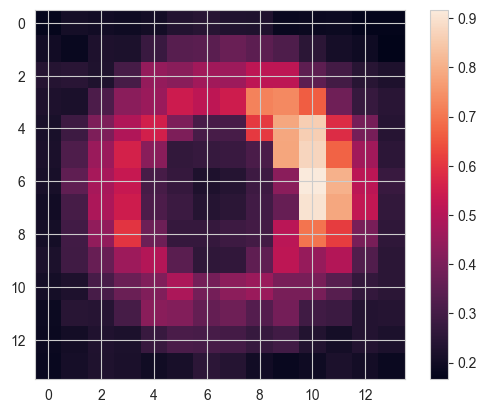

In [179]:
plt.imshow(anomaly_map[5])
plt.colorbar()

In [ ]:
# from scipy.ndimage import gaussian_filter

# anomaly_maps_smooth = gaussian_filter(anomaly_maps, sigma=1)

In [162]:
image_scores_max = anomaly_map.max(axis=(1,2))  # max over all patches per image
image_scores_mean = anomaly_map.mean(axis=(1, 2))  # mean over all patches per image

In [176]:
threshold = np.percentile(image_scores_max, 60)  # choose top 5% as anomalous
pred_labels = (image_scores_max > threshold).astype(int)

print(pred_labels[:50])

[1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 1 0 0 0 1 0 1 0 0 0 1
 1 1 1 1 1 1 1 0 0 0 1 1 1]


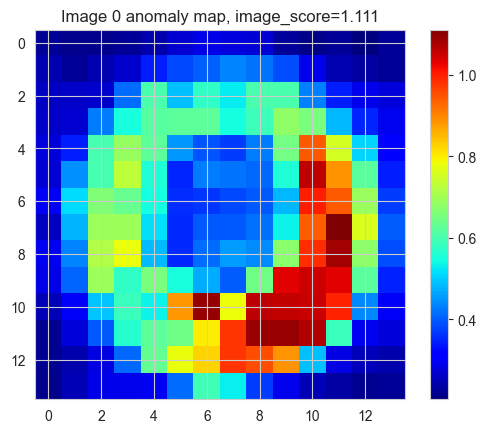

In [177]:
import matplotlib.pyplot as plt

plt.imshow(anomaly_map[0], cmap="jet")
plt.title(f"Image 0 anomaly map, image_score={image_scores_max[0]:.3f}")
plt.colorbar()
plt.show()

In [178]:
true_labels = np.array(
    [0 if label == "good" else 1 for label in test_labels], dtype=int
)
print(true_labels)
accuracy = (pred_labels == true_labels).mean() * 100
print(f"Accuracy: {accuracy:.2f}%")

[1 1 1 ... 1 1 1]
Accuracy: 65.80%


In [15]:
# import numpy as np
# import faiss


# def compute_anomaly_scores(
#     test_patches, index, top_k=5, aggregation="max", N_images=None, N_patches=None
# ):
#     """
#     Compute image-level anomaly scores from patch embeddings using a FAISS index.

#     Parameters
#     ----------
#     test_patches : np.ndarray
#         Either 2D (N_total, D) or 3D (N_images, N_patches, D) patch embeddings.
#     index : faiss.Index
#         FAISS index built from training patches.
#     top_k : int
#         Number of nearest neighbors to consider per patch.
#     aggregation : str
#         How to aggregate patch-level scores to image-level: 'max' or 'mean'.
#     N_images, N_patches : int
#         Required if `test_patches` is 2D, to reshape back to image-level scores.

#     Returns
#     -------
#     img_scores : np.ndarray
#         Image-level anomaly scores, shape (N_images,)
#     """

#     # Convert to float32
#     patches = test_patches.astype("float32")

#     # Determine shape
#     if patches.ndim == 3:
#         N_images, N_patches, D = patches.shape
#         patches_flat = patches.reshape(-1, D)
#     elif patches.ndim == 2:
#         if N_images is None or N_patches is None:
#             raise ValueError("For 2D input, you must provide N_images and N_patches")
#         N_images, N_patches = N_images, N_patches
#         patches_flat = patches
#     else:
#         raise ValueError(f"Invalid input shape: {patches.shape}")

#     # L2-normalize for cosine similarity
#     faiss.normalize_L2(patches_flat)

#     # FAISS search
#     distances, _ = index.search(patches_flat, top_k)  # shape: (N_total, top_k)
#     patch_scores = 1 - distances  # anomaly score = 1 - similarity

#     # Aggregate per patch
#     patch_scores_mean = patch_scores.mean(axis=1)

#     # Reshape to (N_images, N_patches)
#     patch_scores_img = patch_scores_mean.reshape(N_images, N_patches)

#     # Aggregate to image-level
#     if aggregation == "max":
#         img_scores = patch_scores_img.max(axis=1)
#     elif aggregation == "mean":
#         img_scores = patch_scores_img.mean(axis=1)
#     else:
#         raise ValueError(f"Invalid aggregation method: {aggregation}")

#     return img_scores

In [16]:
# import faiss
# import numpy as np


# def build_faiss_index(patch_embeddings):
#     """
#     patch_embeddings: [N_images, N_patches, D] or [N_patches_total, D]
#     Returns: FAISS index for fast nearest neighbor search
#     """
#     # Flatten patches if needed
#     if patch_embeddings.ndim == 3:
#         N_images, N_patches, D = patch_embeddings.shape
#         patch_embeddings_flat = patch_embeddings.reshape(-1, D)
#     else:
#         patch_embeddings_flat = patch_embeddings
#         D = patch_embeddings_flat.shape[1]

#     patch_embeddings_flat = patch_embeddings_flat.astype("float32")
#     faiss.normalize_L2(patch_embeddings_flat)  # cosine similarity

#     index = faiss.IndexFlatIP(D)  # Inner product = cosine similarity
#     index.add(patch_embeddings_flat)
#     return index


# def compute_anomaly_scores(test_patches, index, top_k=5, aggregation="max"):
#     """
#     test_patches: [N_images, N_patches, D]
#     Returns: image-level anomaly scores
#     """
#     N_images, N_patches, D = test_patches.shape
#     test_patches_flat = test_patches.reshape(-1, D).astype("float32")
#     faiss.normalize_L2(test_patches_flat)

#     # kNN search for all patches
#     similarities, _ = index.search(
#         test_patches_flat, k=top_k
#     )  # [N_images*N_patches, top_k]
#     patch_scores = 1 - similarities  # anomaly = 1 - similarity

#     # Reshape back to (N_images, N_patches, top_k) and aggregate per patch
#     patch_scores = patch_scores.mean(axis=1).reshape(N_images, N_patches)

#     # Aggregate to image-level score
#     if aggregation == "max":
#         img_scores = patch_scores.max(axis=1)
#     elif aggregation == "mean":
#         img_scores = patch_scores.mean(axis=1)
#     else:
#         raise ValueError(f"Unknown aggregation: {aggregation}")

#     return img_scores

In [17]:
# import faiss
# import numpy as np

# import faiss


# def build_faiss_index(patch_embeddings, use_gpu=False):
#     """
#     patch_embeddings: np.array [N_patches_total, D], dtype float32
#     """
#     patch_embeddings = patch_embeddings.astype("float32")
#     faiss.normalize_L2(patch_embeddings)  # normalize for cosine similarity
#     D = patch_embeddings.shape[1]

#     # Flat index (no training required)
#     index = faiss.IndexFlatIP(D)
#     index.add(patch_embeddings)  # add all vectors
#     return index


# def compute_anomaly_scores(
#     test_patches, index, top_k=5, batch_size=512, patch_sample=None
# ):
#     """
#     Compute image-level anomaly scores.

#     test_patches: np.array [N_images, N_patches, D]
#     index: FAISS index
#     top_k: number of neighbors
#     batch_size: query batch size
#     patch_sample: if int, randomly sample this many patches per image
#     """
#     N_images, N_patches, D = test_patches.shape

#     # Optional patch subsampling
#     if patch_sample is not None and patch_sample < N_patches:
#         patch_idx = np.random.choice(N_patches, patch_sample, replace=False)
#         test_patches = test_patches[:, patch_idx, :]
#         N_patches = patch_sample

#     # Flatten patches for FAISS
#     test_flat = test_patches.reshape(-1, D).astype("float32")
#     faiss.normalize_L2(test_flat)

#     # Query in batches
#     img_scores = []
#     for start in range(0, test_flat.shape[0], batch_size):
#         end = min(start + batch_size, test_flat.shape[0])
#         batch = test_flat[start:end]
#         sims, _ = index.search(batch, top_k)
#         patch_scores = 1 - sims  # anomaly score = 1 - similarity
#         img_scores.append(patch_scores)

#     patch_scores_all = np.vstack(img_scores).reshape(N_images, N_patches)
#     img_scores_final = patch_scores_all.max(
#         axis=1
#     )  # image-level score: max over patches
#     return img_scores_final

In [18]:
# # Create dataloaders
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# # Step 1: Extract patch embeddings
# # train_patches, train_labels = extract_patch_embeddings(train_loader, "train")

# train_data = load_embeddings_compressed(f"./NEW_embeddings/train_{EMBEDDING_FILE_EXT}")
# train_patches, train_labels = zip(*train_data)

# # embeddings_GT = (
# #     load_embeddings_compressed(train_path)
# #     if os.path.exists(train_path)
# #     else embed_and_save_features(train_loader, "train")
# # )
# # test_patches, test_labels = extract_patch_embeddings(test_loader, "test")
# test_data = load_embeddings_compressed(f"./NEW_embeddings/test_{EMBEDDING_FILE_EXT}")
# test_patches, test_labels = zip(*test_data)

# train_patches = np.stack([np.array(p, dtype=np.float32) for p in train_patches])
# train_labels = np.array(train_labels)

# test_patches = np.stack([np.array(p, dtype=np.float32) for p in test_patches])
# test_labels = np.array(test_labels)

# # Flatten patches: (200, 384) -> (200*384,)
# train_patches_flat = train_patches.reshape(train_patches.shape[0], -1)  # (3629, 76800)
# test_patches_flat = test_patches.reshape(test_patches.shape[0], -1)  # (1725, 76800)


# print(type(train_patches))
# print(train_patches_flat.shape if hasattr(train_patches, "shape") else "no shape")
# print(train_patches.dtype)
# print(train_patches[0])


# # Step 2: Keep only "good" patches for index
# # good_mask = np.array([str(l).lower() == "good" for l in train_labels])
# # good_patches = train_patches[good_mask].reshape(-1, train_patches.shape[2])

# # Step 3: Build FAISS index
# index = build_faiss_index(train_patches)

# # Step 4: Compute anomaly scores
# img_scores = compute_anomaly_scores(
#     test_patches,
#     index,
#     top_k=5,
# )

# # Step 5: Convert to binary prediction
# threshold = 0.95  # tune on validation set
# y_pred = np.array(["good" if s > threshold else "defective" for s in img_scores])
# y_true = np.array(
#     ["good" if str(l).lower() == "good" else "defective" for l in test_labels]
# )

# # Step 6: Compute accuracy
# accuracy = (y_pred == y_true).mean()
# print("Image-level accuracy:", accuracy)

Loading embeddings...
Loading compressed embeddings from: ./NEW_embeddings/train_embeddings.npz
Loaded 3629 embeddings
Loading compressed embeddings from: ./NEW_embeddings/test_embeddings.npz
Loaded 1725 embeddings

Loaded data:
  Train: (3629, 200, 384)
  Test: (1725, 200, 384)

Image-Level Anomaly Classification (K=5)
Training samples: 3629
Test samples: 1725
  Normal: 1258
  Anomaly: 467

Memory bank: 725,800 patches × 384 dims
Using GPU acceleration with chunk_size=500 ✓
Computing anomaly scores...
  Processed 40/1725 images...
  Processed 80/1725 images...
  Processed 120/1725 images...
  Processed 160/1725 images...
  Processed 200/1725 images...
  Processed 240/1725 images...
  Processed 280/1725 images...
  Processed 320/1725 images...
  Processed 360/1725 images...
  Processed 400/1725 images...
  Processed 440/1725 images...
  Processed 480/1725 images...
  Processed 520/1725 images...
  Processed 560/1725 images...
  Processed 600/1725 images...
  Processed 640/1725 images..

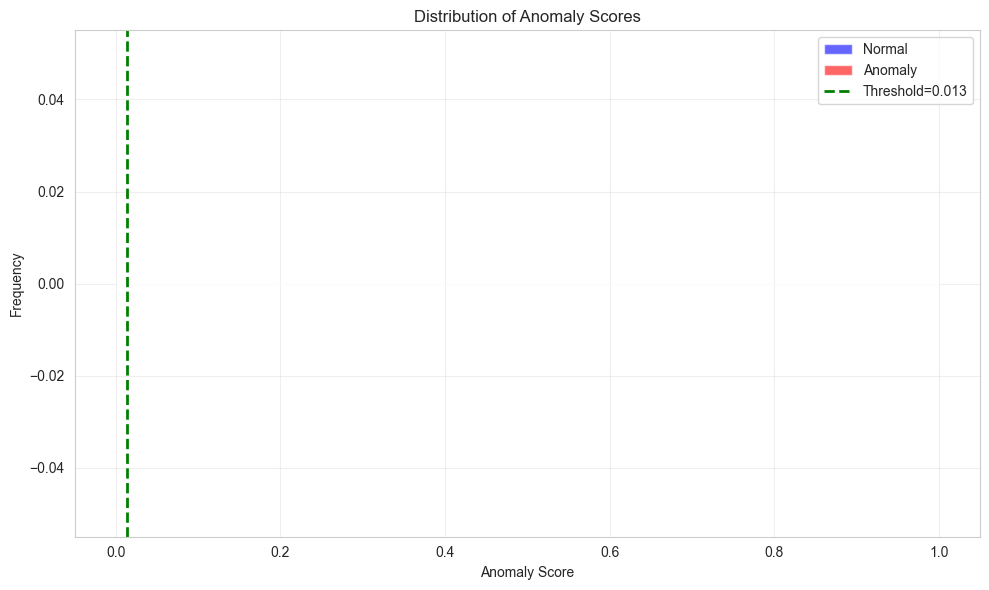

In [25]:
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt


class FastPatchAnomalyDetector:
    """
    Memory-efficient patch-based anomaly detector for image-level classification.
    """

    def __init__(self, train_patches, k=5, use_gpu=True, chunk_size=1000):
        """
        Args:
            train_patches: [N_train, N_patches, D] - normal training patch embeddings
            k: Number of nearest neighbors
            use_gpu: Use GPU for faster computation
            chunk_size: Process train patches in chunks to save memory
        """
        self.k = k
        self.use_gpu = use_gpu and torch.cuda.is_available()
        self.chunk_size = chunk_size

        # Flatten all training patches into memory bank
        N_train, N_patches, D = train_patches.shape
        self.train_patches_flat = train_patches.reshape(-1, D)  # [N_train*N_patches, D]
        self.N_patches = N_patches
        self.D = D
        self.N_train_patches = self.train_patches_flat.shape[0]

        print(f"Memory bank: {self.N_train_patches:,} patches × {D} dims")

        # Normalize
        if self.use_gpu:
            # Keep on CPU, will move to GPU in chunks
            norms = np.linalg.norm(self.train_patches_flat, axis=1, keepdims=True)
            self.train_patches_flat = self.train_patches_flat / (norms + 1e-8)
            print(f"Using GPU acceleration with chunk_size={chunk_size} ✓")
        else:
            norms = np.linalg.norm(self.train_patches_flat, axis=1, keepdims=True)
            self.train_patches_flat = self.train_patches_flat / (norms + 1e-8)
            print("Using CPU (slower)")

    def predict_batch(self, test_patches_batch):
        """
        Compute anomaly scores for a batch of test images.
        Uses chunked processing to avoid OOM errors.

        Args:
            test_patches_batch: [N_test, N_patches, D]

        Returns:
            anomaly_scores: [N_test] - one score per image
        """
        N_test = len(test_patches_batch)

        # Flatten test patches: [N_test*N_patches, D]
        test_patches_flat = test_patches_batch.reshape(-1, self.D)

        # Normalize
        test_norms = np.linalg.norm(test_patches_flat, axis=1, keepdims=True)
        test_patches_flat = test_patches_flat / (test_norms + 1e-8)

        N_test_patches = test_patches_flat.shape[0]

        if self.use_gpu:
            # Move test patches to GPU
            test_patches_gpu = torch.from_numpy(test_patches_flat).float().cuda()

            # Store top-k similarities for each test patch
            # We'll compute similarities in chunks of training patches
            all_topk_sims = []

            # Process training patches in chunks
            for chunk_start in range(0, self.N_train_patches, self.chunk_size):
                chunk_end = min(chunk_start + self.chunk_size, self.N_train_patches)

                # Load chunk of training patches to GPU
                train_chunk = (
                    torch.from_numpy(self.train_patches_flat[chunk_start:chunk_end])
                    .float()
                    .cuda()
                )

                # Compute similarities for this chunk: [N_test_patches, chunk_size]
                similarities_chunk = torch.mm(test_patches_gpu, train_chunk.T)

                # Get top-k from this chunk
                topk_chunk, _ = torch.topk(
                    similarities_chunk,
                    k=min(self.k, similarities_chunk.shape[1]),
                    dim=1,
                )
                all_topk_sims.append(topk_chunk)

                # Free memory
                del train_chunk, similarities_chunk
                torch.cuda.empty_cache()

            # Combine top-k from all chunks and get final top-k
            all_topk_sims = torch.cat(all_topk_sims, dim=1)  # [N_test_patches, total_k]
            final_topk, _ = torch.topk(all_topk_sims, k=self.k, dim=1)

            # Anomaly score per patch
            patch_scores = 1 - final_topk.mean(dim=1)
            patch_scores = patch_scores.cpu().numpy()

            # Clean up
            del test_patches_gpu, all_topk_sims, final_topk
            torch.cuda.empty_cache()

        else:
            # CPU version - also chunked for consistency
            all_topk_sims = []

            for chunk_start in range(0, self.N_train_patches, self.chunk_size):
                chunk_end = min(chunk_start + self.chunk_size, self.N_train_patches)
                train_chunk = self.train_patches_flat[chunk_start:chunk_end]

                # Compute similarities
                similarities_chunk = np.dot(test_patches_flat, train_chunk.T)

                # Get top-k from this chunk
                k_this_chunk = min(self.k, similarities_chunk.shape[1])
                topk_indices = np.argpartition(
                    similarities_chunk, -k_this_chunk, axis=1
                )[:, -k_this_chunk:]
                topk_chunk = np.take_along_axis(
                    similarities_chunk, topk_indices, axis=1
                )
                all_topk_sims.append(topk_chunk)

            # Combine and get final top-k
            all_topk_sims = np.concatenate(all_topk_sims, axis=1)
            topk_indices = np.argpartition(all_topk_sims, -self.k, axis=1)[:, -self.k :]
            final_topk = np.take_along_axis(all_topk_sims, topk_indices, axis=1)

            # Anomaly scores
            patch_scores = 1 - final_topk.mean(axis=1)

        # Reshape to [N_test, N_patches]
        patch_scores = patch_scores.reshape(N_test, self.N_patches)

        # Image-level anomaly score: max patch score
        anomaly_scores = patch_scores.max(axis=1)

        return anomaly_scores


def evaluate_image_classification(
    train_patches,
    test_patches,
    test_labels,
    k=5,
    batch_size=16,  # Smaller batch size for memory
    chunk_size=1000,  # Adjust based on your GPU memory
    threshold=None,
):
    """
    Evaluate image-level anomaly classification (memory-efficient).

    Args:
        train_patches: [N_train, N_patches, D] from normal images
        test_patches: [N_test, N_patches, D] from test images
        test_labels: [N_test] - 0=normal, 1=anomaly
        k: Number of nearest neighbors
        batch_size: Batch size for processing test images
        chunk_size: Chunk size for training patches (reduce if OOM)
        threshold: Classification threshold (if None, will find optimal)

    Returns:
        results: Dictionary with all metrics
    """
    print(f"\n{'='*60}")
    print(f"Image-Level Anomaly Classification (K={k})")
    print(f"{'='*60}")
    print(f"Training samples: {len(train_patches)}")
    print(f"Test samples: {len(test_patches)}")
    print(f"  Normal: {(test_labels == 0).sum()}")
    print(f"  Anomaly: {(test_labels == 1).sum()}")
    print(f"{'='*60}\n")

    # Build detector with memory-efficient chunking
    detector = FastPatchAnomalyDetector(
        train_patches, k=k, use_gpu=True, chunk_size=chunk_size
    )

    # Compute anomaly scores for all test images
    all_scores = []
    N_test = len(test_patches)

    print("Computing anomaly scores...")
    for i in range(0, N_test, batch_size):
        batch = test_patches[i : i + batch_size]
        scores = detector.predict_batch(batch)
        all_scores.append(scores)

        if (i // batch_size + 1) % 5 == 0:
            print(f"  Processed {min(i+batch_size, N_test)}/{N_test} images...")

    anomaly_scores = np.concatenate(all_scores)

    # Calculate ROC-AUC
    auc = roc_auc_score(test_labels, anomaly_scores)

    # Find optimal threshold
    if threshold is None:
        from sklearn.metrics import precision_recall_curve

        precision, recall, thresholds = precision_recall_curve(
            test_labels, anomaly_scores
        )
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
        optimal_idx = np.argmax(f1_scores)
        threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5
        print(f"\nOptimal threshold: {threshold:.4f}")

    # Make predictions
    predictions = (anomaly_scores > threshold).astype(int)

    # Calculate metrics
    cm = confusion_matrix(test_labels, predictions)
    tn, fp, fn, tp = cm.ravel()

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = (
        2 * (precision * recall) / (precision + recall)
        if (precision + recall) > 0
        else 0
    )

    # Print results
    print(f"\n{'='*60}")
    print(f"RESULTS")
    print(f"{'='*60}")
    print(f"ROC-AUC:        {auc:.4f}")
    print(f"Accuracy:       {accuracy:.4f}")
    print(f"Precision:      {precision:.4f}")
    print(f"Recall:         {recall:.4f}")
    print(f"F1 Score:       {f1:.4f}")
    print(f"\nConfusion Matrix:")
    print(f"                 Predicted")
    print(f"                 Normal  Anomaly")
    print(f"Actual Normal    {tn:6d}  {fp:6d}")
    print(f"       Anomaly   {fn:6d}  {tp:6d}")
    print(f"{'='*60}\n")

    # Show score distributions
    normal_scores = anomaly_scores[test_labels == 0]
    anomaly_scores_pos = anomaly_scores[test_labels == 1]

    print(f"Anomaly Score Statistics:")
    print(f"  Normal images:  {normal_scores.mean():.4f} ± {normal_scores.std():.4f}")
    print(
        f"  Anomaly images: {anomaly_scores_pos.mean():.4f} ± {anomaly_scores_pos.std():.4f}"
    )

    return {
        "auc": auc,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "threshold": threshold,
        "confusion_matrix": cm,
        "anomaly_scores": anomaly_scores,
        "predictions": predictions,
    }


def plot_score_distribution(anomaly_scores, test_labels, threshold=None):
    """Visualize anomaly score distributions."""
    normal_scores = anomaly_scores[test_labels == 0]
    anomaly_scores_pos = anomaly_scores[test_labels == 1]

    plt.figure(figsize=(10, 6))
    plt.hist(normal_scores, bins=50, alpha=0.6, label="Normal", color="blue")
    plt.hist(anomaly_scores_pos, bins=50, alpha=0.6, label="Anomaly", color="red")

    if threshold is not None:
        plt.axvline(
            threshold,
            color="green",
            linestyle="--",
            linewidth=2,
            label=f"Threshold={threshold:.3f}",
        )

    plt.xlabel("Anomaly Score")
    plt.ylabel("Frequency")
    plt.title("Distribution of Anomaly Scores")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


# ============================================================================
# USAGE
# ============================================================================

if __name__ == "__main__":
    # EMBEDDING_FILE_EXT = "bottle"

    # Load embeddings
    print("Loading embeddings...")
    train_data = load_embeddings_compressed(
        f"./NEW_embeddings/train_{EMBEDDING_FILE_EXT}"
    )
    test_data = load_embeddings_compressed(
        f"./NEW_embeddings/test_{EMBEDDING_FILE_EXT}"
    )

    # Unpack
    train_patches = np.array([emb for emb, _ in train_data])
    test_patches = np.array([emb for emb, _ in test_data])
    test_labels = np.array([label for _, label in test_data])
    y_true = np.array([1 if str(l).lower() == "good" else 0 for l in test_labels])

    print(f"\nLoaded data:")
    print(f"  Train: {train_patches.shape}")
    print(f"  Test: {test_patches.shape}")

    # Evaluate with memory-efficient processing
    results = evaluate_image_classification(
        train_patches,
        test_patches,
        y_true,
        k=5,
        batch_size=8,  # Reduced for 4GB GPU
        chunk_size=500,  # Adjust: 500-1000 for 4GB, 2000-5000 for larger GPUs
    )

    # Plot
    plot_score_distribution(
        results["anomaly_scores"], test_labels, threshold=results["threshold"]
    )

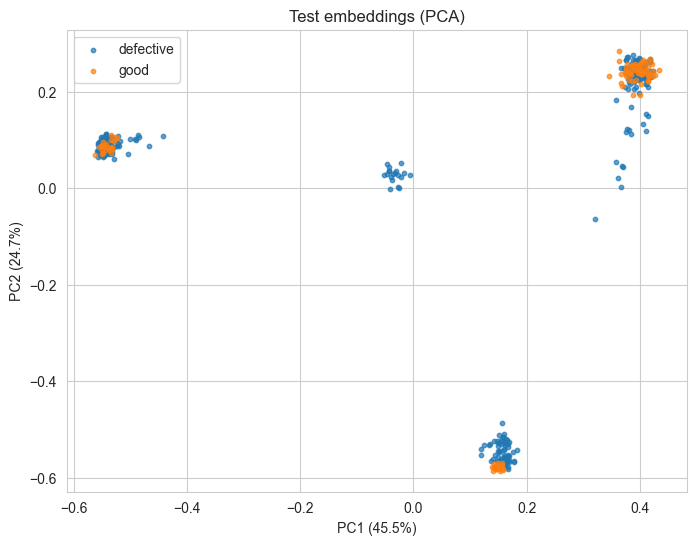

In [65]:
X_test, y_test = load_embeddings_only(
    "./NEW_embeddings/test_embeddings.npz",
)

# X_test.shape -> (num_images, num_patches, patch_dim)
num_images = X_test.shape[0]
X_test_flat = X_test.reshape(num_images, -1)  # (num_images, num_patches*patch_dim)


y_bin = ["good" if str(label).lower() == "good" else "defective" for label in y_test]

y_bin = np.array(y_bin)

visualize_pca(X_test_flat, y_bin, "Test embeddings (PCA)")